# Setup
Let's import the required libraries, download the dataset and decompress the data.

In [0]:
!pip install pandas-summary kaggle
!pip install kaggle --upgrade
!pip install psutil

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import statistics

from fastai.imports import *
# from fastai.structured import *

from pandas_summary import DataFrameSummary
from IPython.display import display

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import psutil

In [0]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [0]:
!kaggle competitions download -c ieee-fraud-detection

In [0]:
!unzip test_identity.csv.zip 
!unzip test_transaction.csv.zip
!unzip train_transaction.csv.zip
!unzip train_identity.csv.zip

In [0]:
df_test_identity = pd.read_csv('test_identity.csv', low_memory=False)
df_test_transaction = pd.read_csv('test_transaction.csv', low_memory=False)
df_train_identity = pd.read_csv('train_identity.csv', low_memory=False)
df_train_transaction = pd.read_csv('train_transaction.csv', low_memory=False)

# Data structure
A high level look at the data structure, data types and number of records etc.


In [7]:
print('{} training examples and {} test examples.'.format(len(df_train_transaction), len(df_test_transaction)))
print('{} records in our training identity dataset and {} in our test set.'.format(len(df_train_identity), len(df_test_identity)))

590540 training examples and 506691 test examples.
144233 records in our training identity dataset and 141907 in our test set.


In [0]:
# Join two datasets
train = pd.merge(df_train_transaction, df_train_identity, on='TransactionID', how='left')
test = pd.merge(df_test_transaction, df_test_identity, on='TransactionID', how='left')
del df_train_identity, df_train_transaction, df_test_identity, df_test_transaction

In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
display_all(train.tail())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,T,T,T,M0,T,F,F,F,T,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0,47.950001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0,47.950001,0.0,0.0,47.950001,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0

In [11]:
print([data_type for data_type in train.dtypes])

[dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('O'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('floa

In [12]:
print('There are {} columns in train dataset with missing values.'.format(train.isnull().any().sum()))

There are 414 columns in train dataset with missing values.


In [13]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [14]:
print('There are {} columns in train dataset with one unique value.'.format(len(one_value_cols)))
print('There are {} columns in test dataset with one unique value.'.format(len(one_value_cols_test)))

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [0]:
one_value_cols = [col for col in train.columns if train[col].nunique() < 3]
one_value_cols_test = [col for col in test.columns if test[col].nunique() < 3]

In [16]:
print('There are {} boolean columns in train dataset.'.format(len(one_value_cols)))
print('There are {} boolean columns in test dataset.'.format(len(one_value_cols_test)))

There are 26 boolean columns in train dataset.
There are 26 boolean columns in test dataset.


Percentage of data belonging to minority class (isFraud == 1): 3.5 %


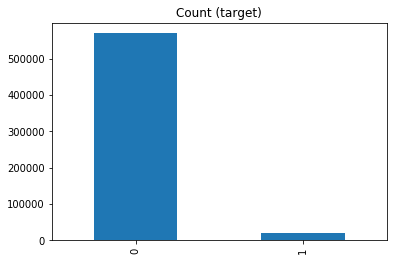

In [17]:
train.isFraud.value_counts().plot(kind='bar', title='Count (target)')
print('Percentage of data belonging to minority class (isFraud == 1):', round(sum(train.isFraud)/len(train)*100, 2), '%')

In [18]:
print([[train[col].value_counts()] for col in train.columns])

[[3147775    1
3089230    1
3189951    1
3187902    1
3194045    1
          ..
3043995    1
3046042    1
3039897    1
3041944    1
3145728    1
Name: TransactionID, Length: 590540, dtype: int64], [0    569877
1     20663
Name: isFraud, dtype: int64], [9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
           ..
1297707     1
1309997     1
257327      1
11738417    1
8388608     1
Name: TransactionDT, Length: 573349, dtype: int64], [59.000      30582
117.000     28933
107.950     23954
57.950      23600
100.000     20362
            ...  
20.225          1
1049.500        1
10.600          1
274.480         1
1370.220        1
Name: TransactionAmt, Length: 20902, dtype: int64], [W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64], [7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
12390        1
10341        1
10006        1
15743        1
17105        1
Name: card1, Length: 13553, dty

We can get a rough feel for our data from this initial exploration - data is:
- categorical - ProductCD [W, C, R, H, S]
- continous - TransactionAmt [0.251:31937.391]
- Boolean - M7 [T, F]
- Heavily class imbalanced.  




# Data discussion
[Information](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) relating to the columns from the competition host.
## Transaction table
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

## Indentity table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s (competition host) fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
* DeviceType
* DeviceInfo
* id12 - id38

# Columns

## id_x columns

In [0]:
def plot_idx(df, offset = 0, plot_count = 10):
  fig = plt.figure(figsize=(20,10))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  start = offset+1
  end = start+plot_count

  for i in range(start, end):
      plt.subplot(2, 5, i-offset)
      # Column name
      if (i < 10):
        col = 'id_0'+ str(i)
      else:
        col = 'id_'+ str(i)
      # Plot type
      if (train[col].dtype == np.float64):
        ax = sns.distplot(train[col].dropna(), bins=20)
      else:
        ax = sns.countplot(train[col].dropna(), hue=train['isFraud'])
      ax.set_title('% NA: {}'.format(round(sum(train[col].isna())/len(train), 2)))

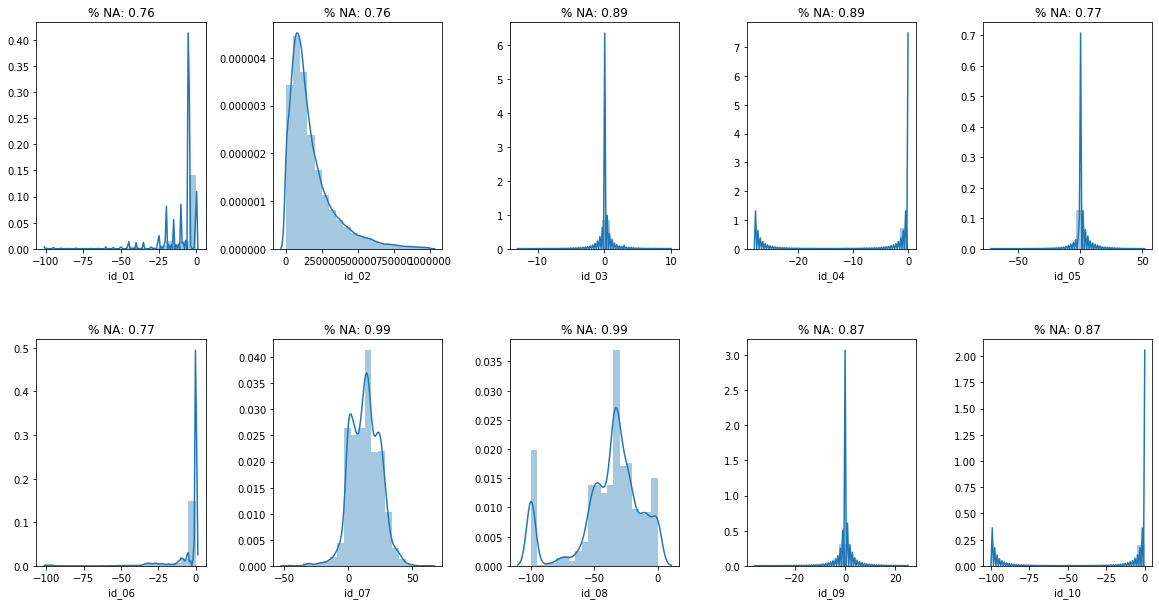

In [20]:
plot_idx(train)

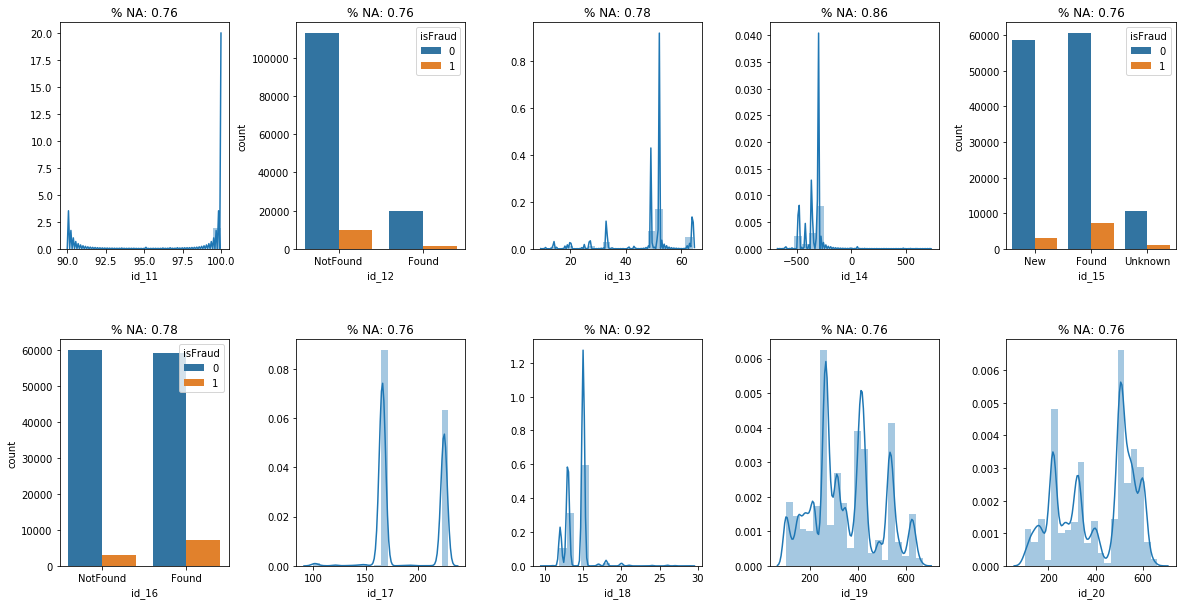

In [21]:
plot_idx(train, offset=10)

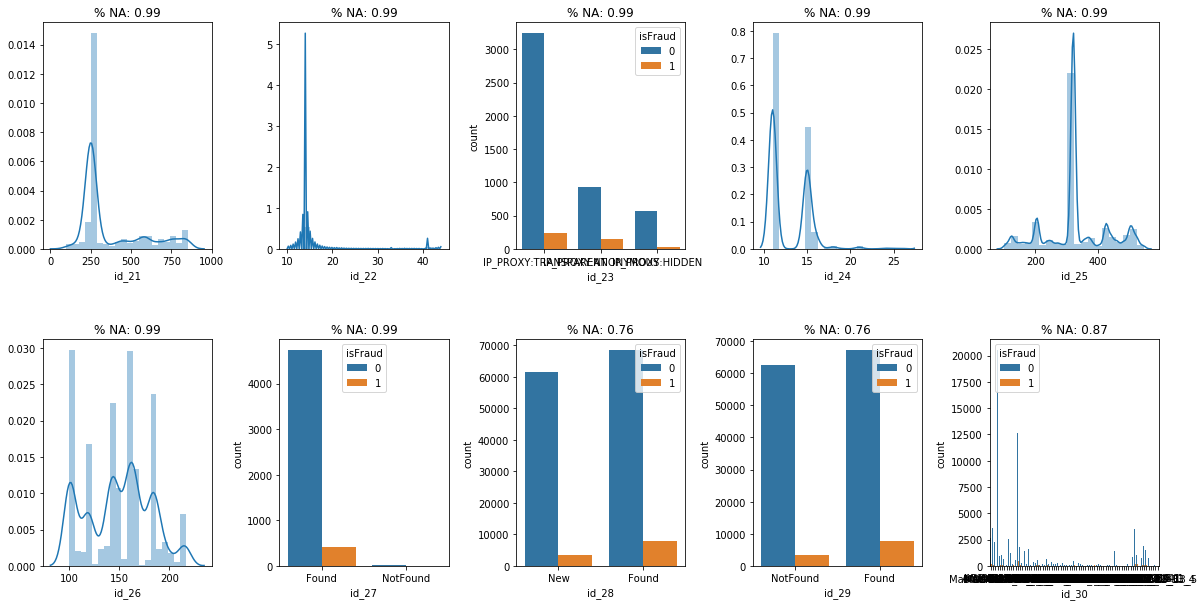

In [22]:
plot_idx(train, offset=20)

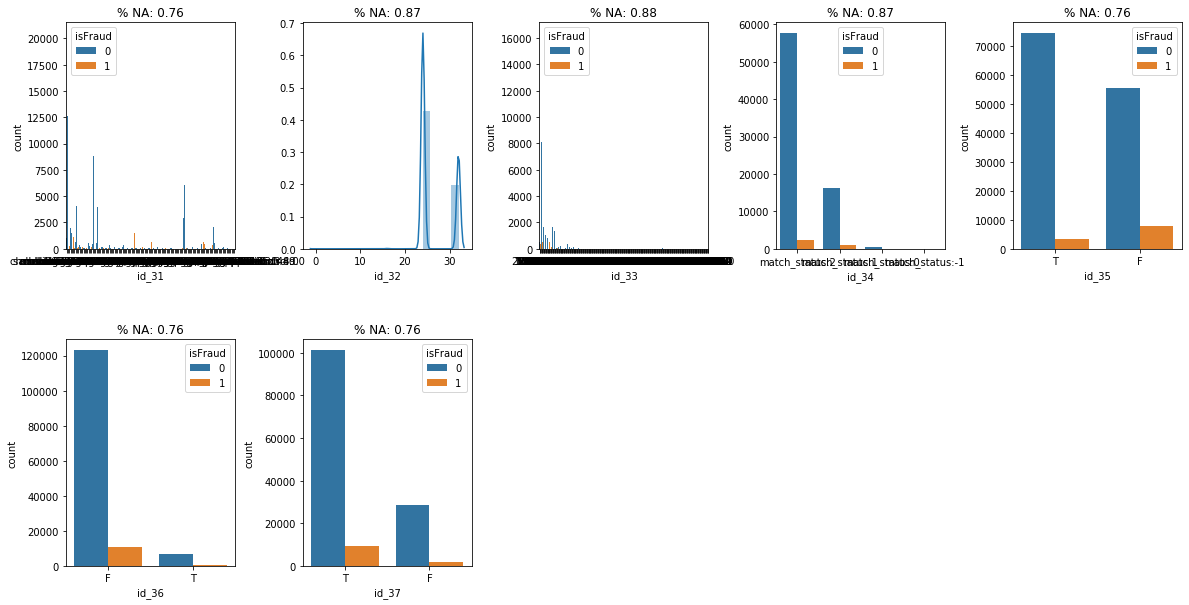

In [23]:
plot_idx(train, offset=30, plot_count=7)

Some of the variables seem to have been normalized, as the data is distributed around a center (id_3, id_5, id_9, id_25). For many variables we also have extremely high NA counts (up to 99%). Let's have a further look at the columns that multiple unique values, that could not be interpreted from the above plots.


In [24]:
train.id_34.unique()[:10]

array([nan, 'match_status:2', 'match_status:1', 'match_status:0',
       'match_status:-1'], dtype=object)

In [25]:
train.id_33.unique()[:10]

array([nan, '2220x1080', '1334x750', '1280x800', '1366x768', '1920x1080',
       '1680x1050', '1136x640', '5120x2880', '2880x1800'], dtype=object)

This seems to be a screen resolution. 

In [26]:
train.id_31.unique()[:10]

array([nan, 'samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0',
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0'], dtype=object)

This is browser information - a variable that could be discriminant w.r.t fraud either as a stand-alone feature or part of complex interaction of features. 

In [27]:
train.id_30.unique()[:10]

array([nan, 'Android 7.0', 'iOS 11.1.2', 'Mac OS X 10_11_6', 'Windows 10',
       'Android', 'Linux', 'iOS 11.0.3', 'Mac OS X 10_7_5',
       'Mac OS X 10_12_6'], dtype=object)

This is device OS info. 

In [28]:
train.id_23.unique()[:10]

array([nan, 'IP_PROXY:TRANSPARENT', 'IP_PROXY:ANONYMOUS',
       'IP_PROXY:HIDDEN'], dtype=object)

In [29]:
print([col for col in train.columns])

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

## Card

In [0]:
def plot_card(df):
  fig = plt.figure(figsize=(30,5))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(1, 7):
    plt.subplot(1, 6, i)
    col = 'card' + str(i)
    if (train[col].dtype == np.float64 or train[col].dtype == np.int64):
      ax = sns.distplot(train[col].dropna(), bins=20)
    elif(train[col].dtype == 'O'):
      ax = sns.countplot(train[col].dropna(), hue=train['isFraud'])
    ax.set_title('% NA: {}'.format(round(sum(train[col].isna())/len(train), 2)))

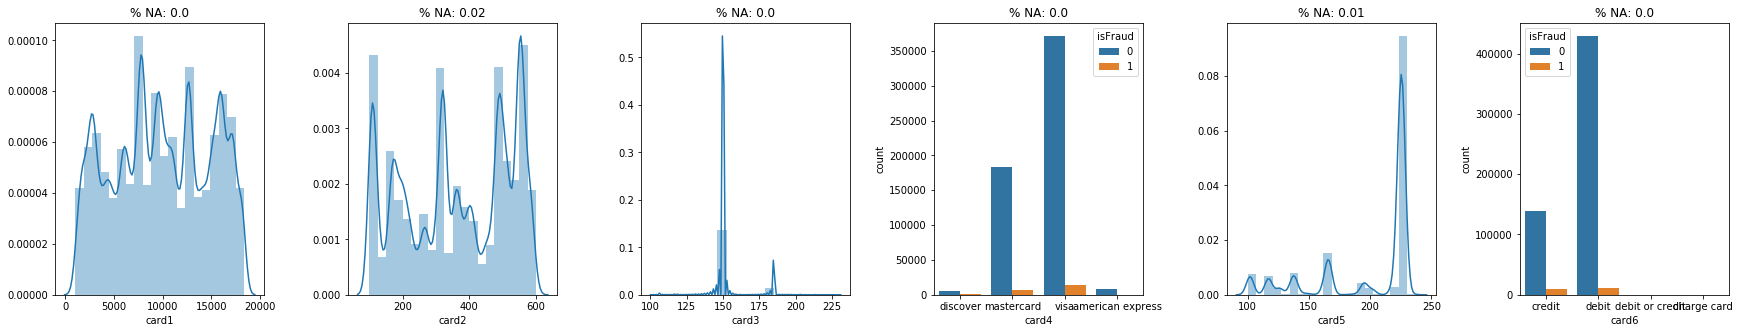

In [31]:
plot_card(train)

## CXX

In [0]:
# Pull out just the columns we're interest in - much faster plotting execution time (Ran into memeory issues before doing this). 
CXXX = train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'isFraud']].astype('float32')

In [0]:
avail_RAM = psutil.virtual_memory()[0]
if avail_RAM/1e9 > 32:
  t = time.time()
  sns.catplot(x="isFraud", y="C1", data=train)
  print('visualization time of 1 column w/ full dataframe: {}s'.format(round(time.time() - t), 2))

visualization time of 1 column w/ reduced dataframe: 1s


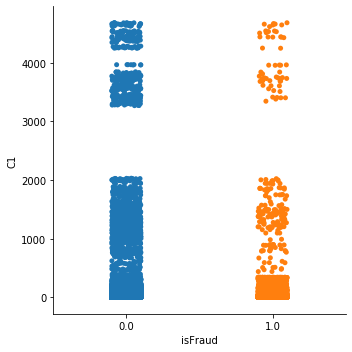

In [35]:
t = time.time()
sns.catplot(x="isFraud", y="C1", data=CXXX)
print('visualization time of 1 column w/ reduced dataframe: {}s'.format(round(time.time()-t), 2))

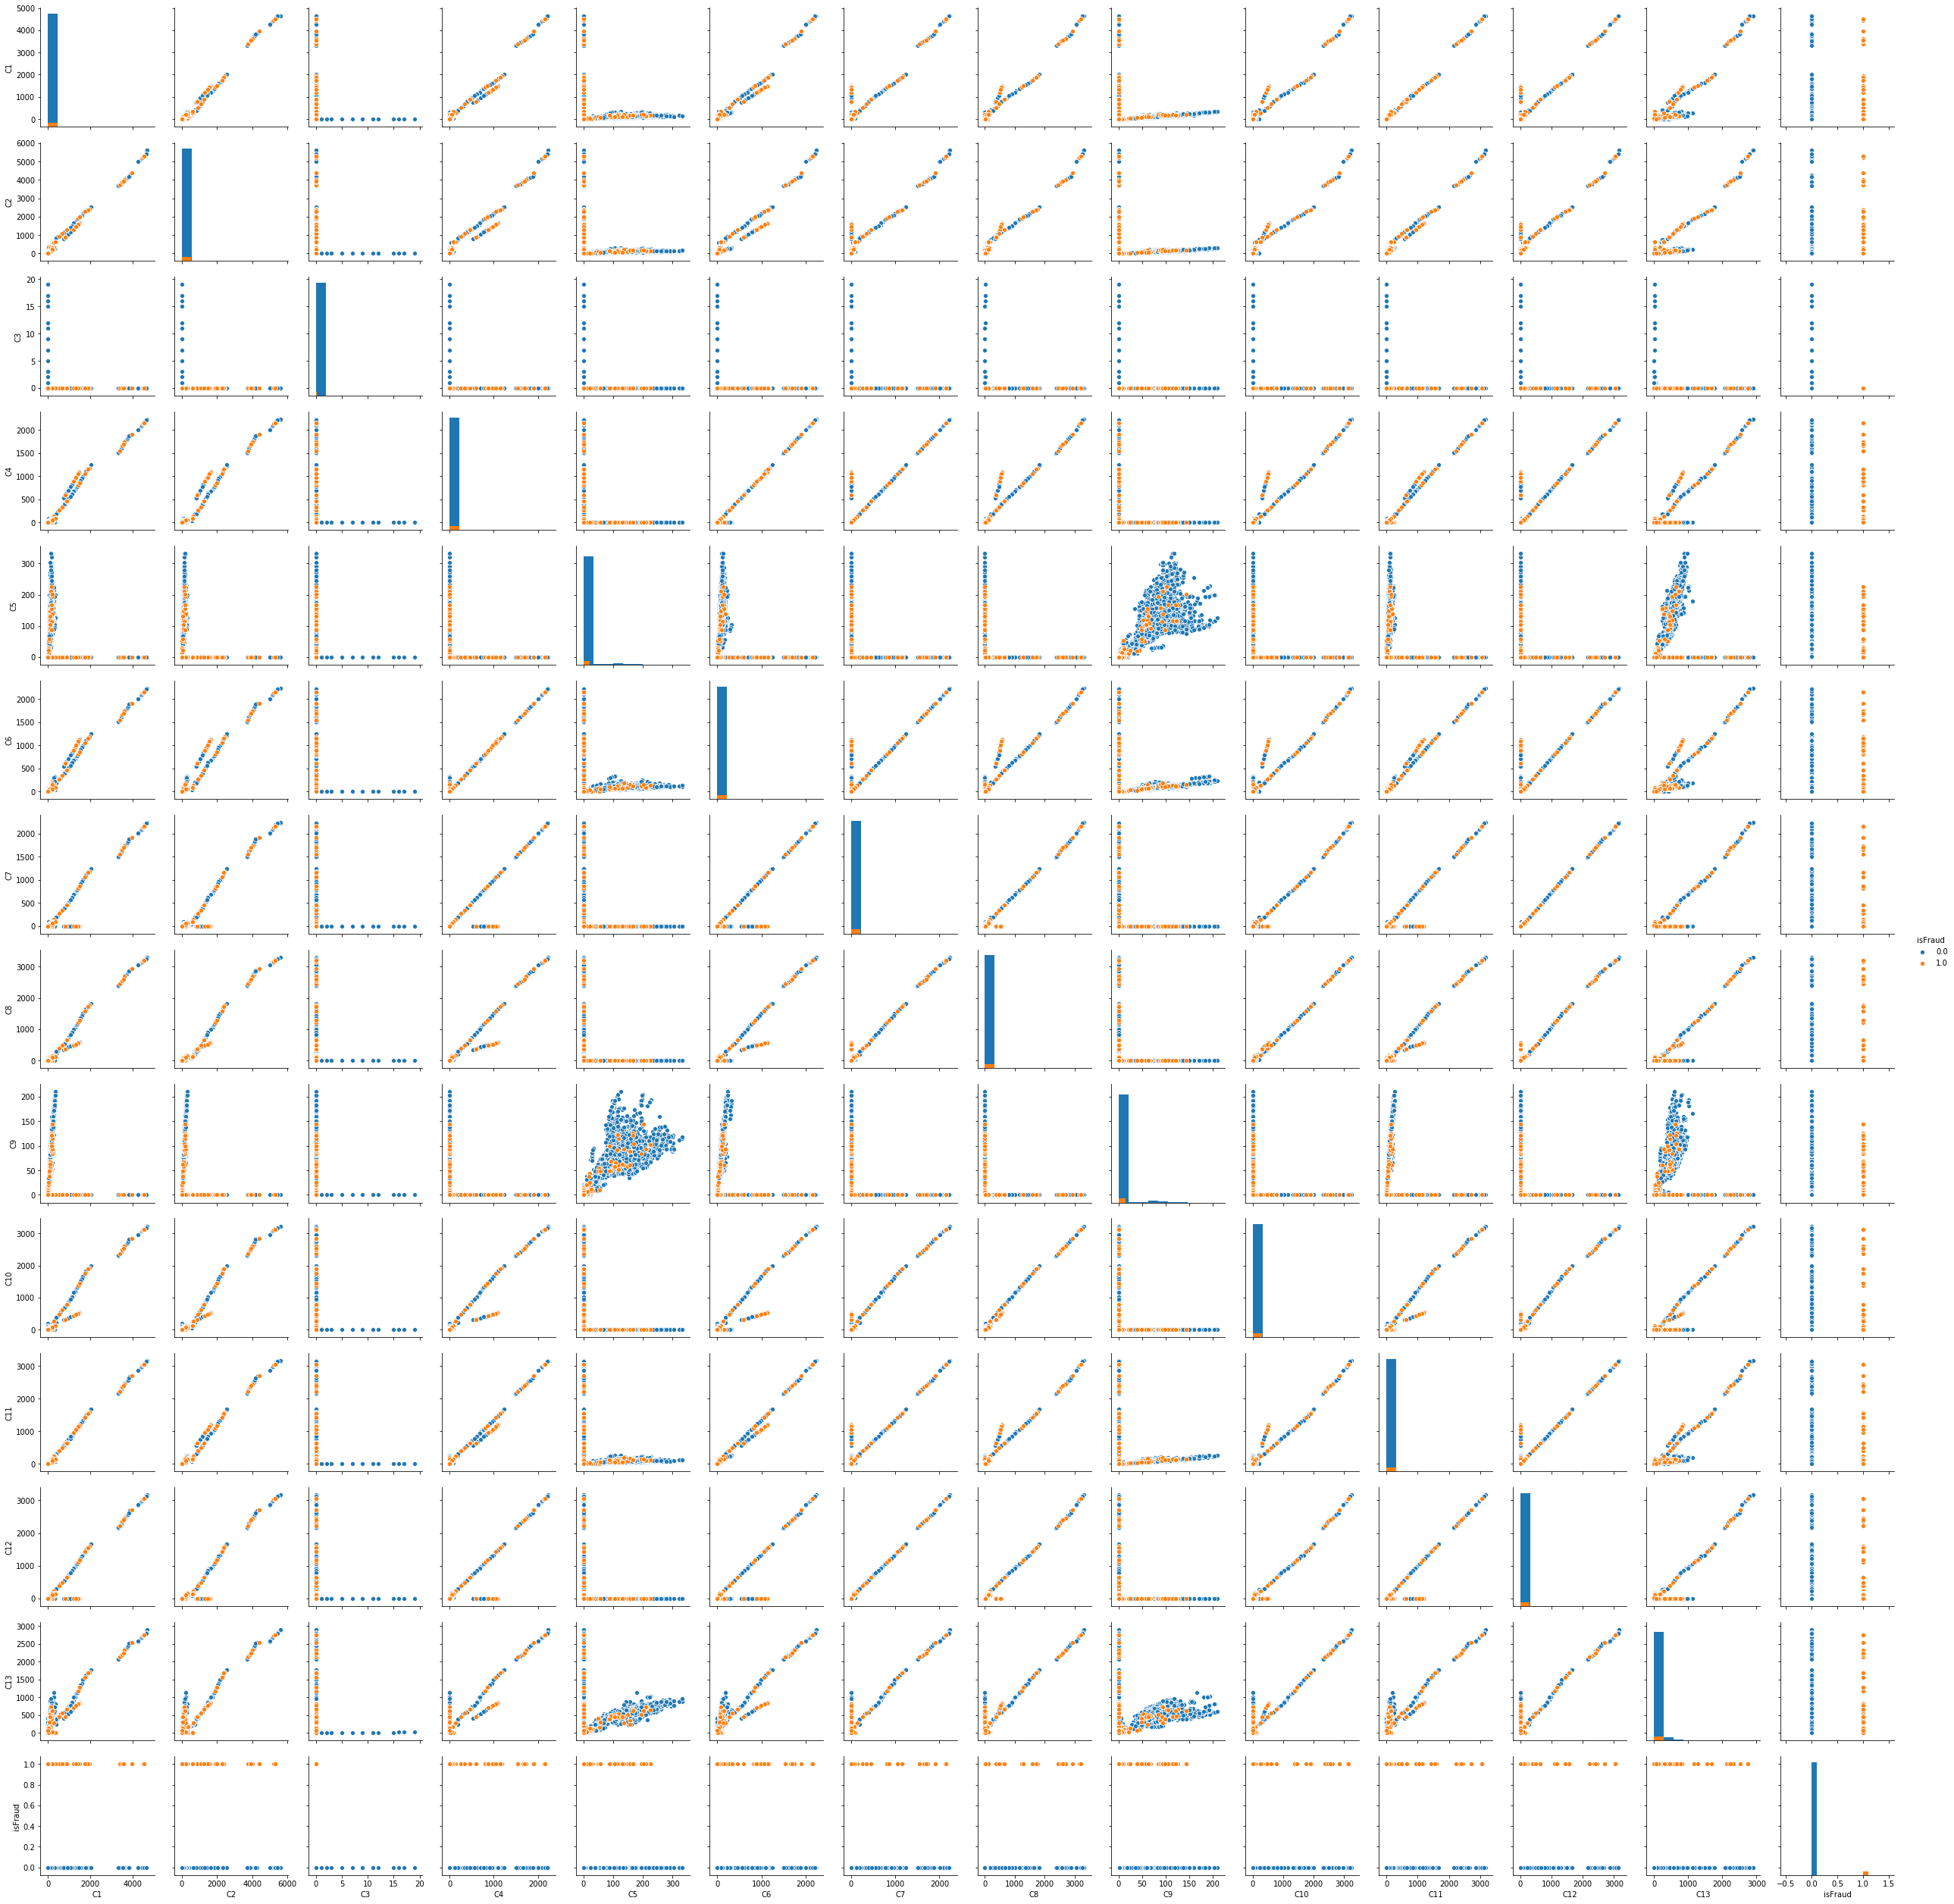

In [39]:
sns.pairplot(CXXX.sample(100000), diag_kind='hist', hue='isFraud', height=2.5);

In [40]:
CXXX.query('isFraud == 1')['C3'].sum()

5.0

In [41]:
CXXX.query('isFraud == 0')[0:22000]['C3'].sum()

350.0

## Addr & dist
addr1	addr2	dist1	dist2

In [0]:
addr_dist = train[['addr1', 'addr2', 'dist1', 'dist2', 'isFraud']]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


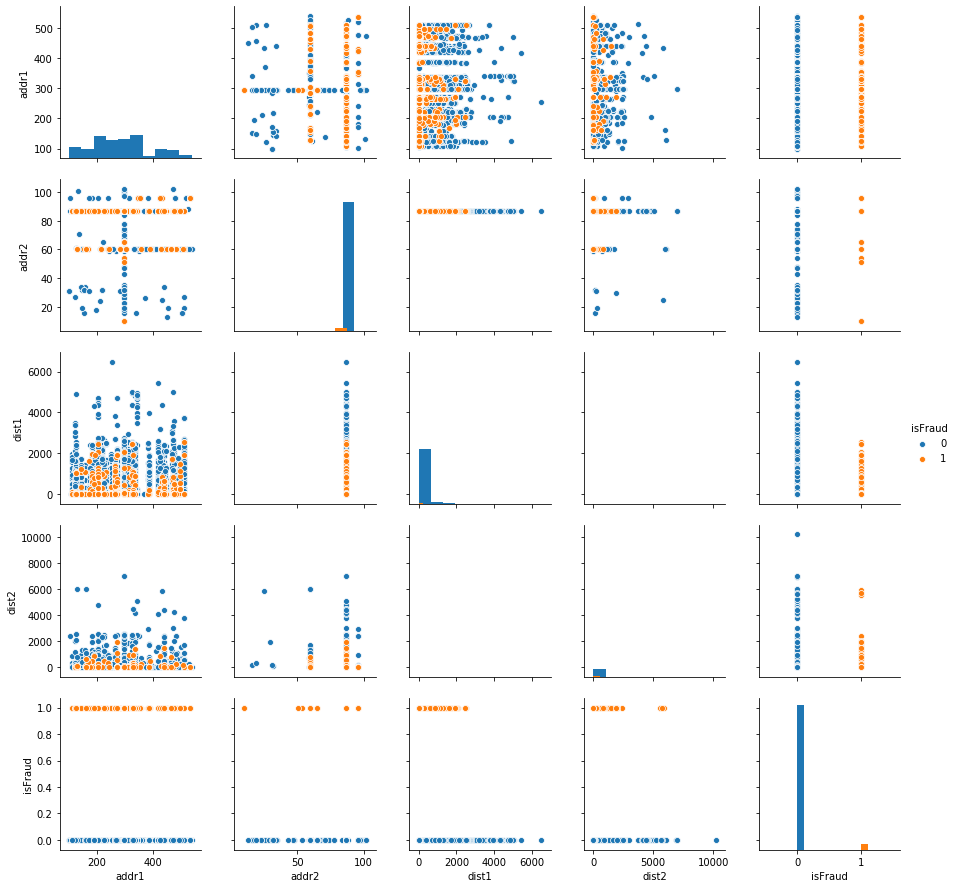

In [44]:
sns.pairplot(addr_dist.sample(100000), diag_kind='hist', hue='isFraud', height=2.5);

## D1-D15

In [45]:
DXX = train[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'isFraud']].astype('float32')
sns.pairplot(DXX.sample(100000), diag_kind='hist', hue='isFraud', height=2.5);

Output hidden; open in https://colab.research.google.com to view.

## M1-9

In [0]:
def plot_M(df, offset = 0, plot_count = 9):
  fig = plt.figure(figsize=(20,10))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  start = offset+1
  end = start+plot_count

  for i in range(start, end):
      plt.subplot(2, 5, i-offset)
      col = 'M'+ str(i)
      ax = sns.countplot(train[col].dropna(), hue=train['isFraud'])
      ax.set_title('% NA: {}'.format(round(sum(train[col].isna())/len(train), 2)))

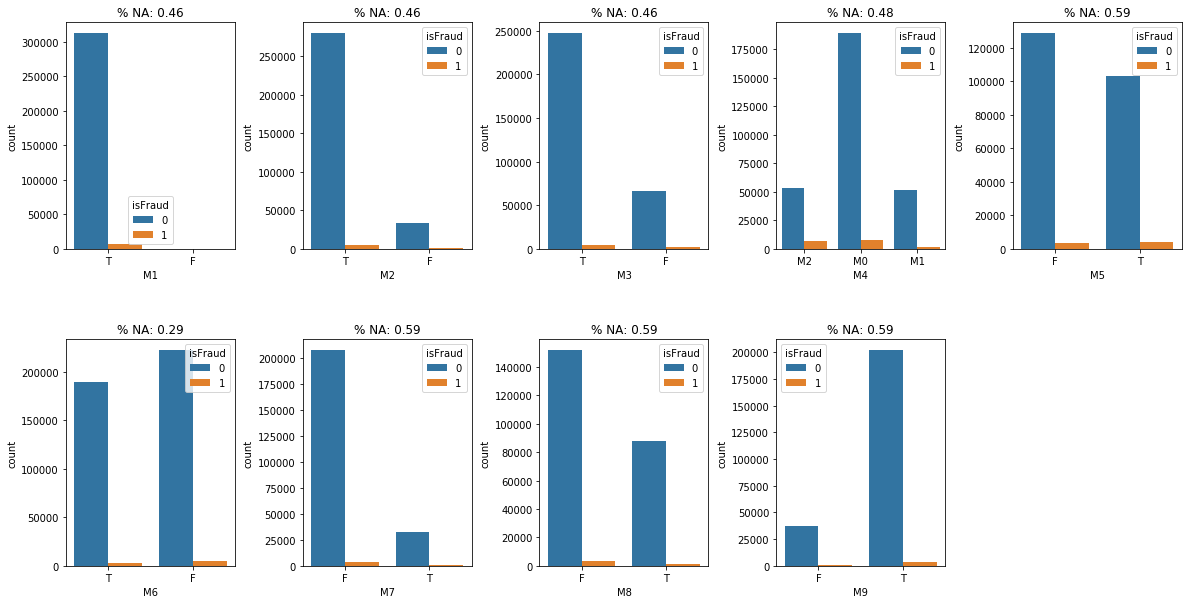

In [47]:
plot_M(train)

## Transaction amount

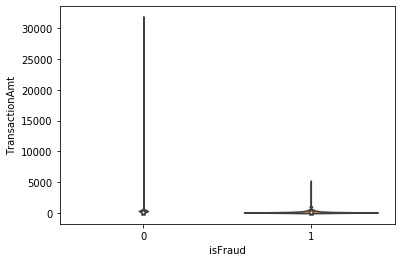

In [48]:
ax = sns.violinplot(x='isFraud', y='TransactionAmt', data=train)

In [49]:
len(train.query('isFraud == 0 and TransactionAmt > 5000'))

17

In [0]:
train['TransactionAmt_clip'] = train['TransactionAmt'].clip(upper=5000)

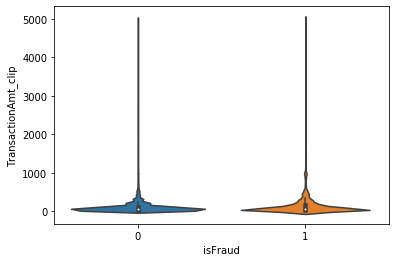

In [51]:
ax = sns.violinplot(x='isFraud', y='TransactionAmt_clip', data=train)

## ProductCD

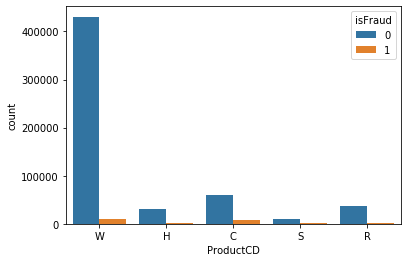

In [52]:
ax = sns.countplot(x='ProductCD', data=train, hue='isFraud')

## VXXX 
To visualize each feature would be too exhaustive - there are 339 columns that represent features engineered by [Vesta](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)


In [0]:
def plot_VXXX(df, offset=0):
  fig = plt.figure(figsize=(30,10))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range((offset+1), (offset+31)):
    plt.subplot(2, 15, i-offset)
    col = 'V' + str(i)
    if (train[col].dtype == np.float64):
      ax = sns.distplot(train[col].dropna(), bins=20)
    else:
      ax = sns.countplot(train[col].dropna(), hue=train['isFraud'])
    ax.set_title('% NA: {}'.format(round(sum(train[col].isna())/len(train), 2)))

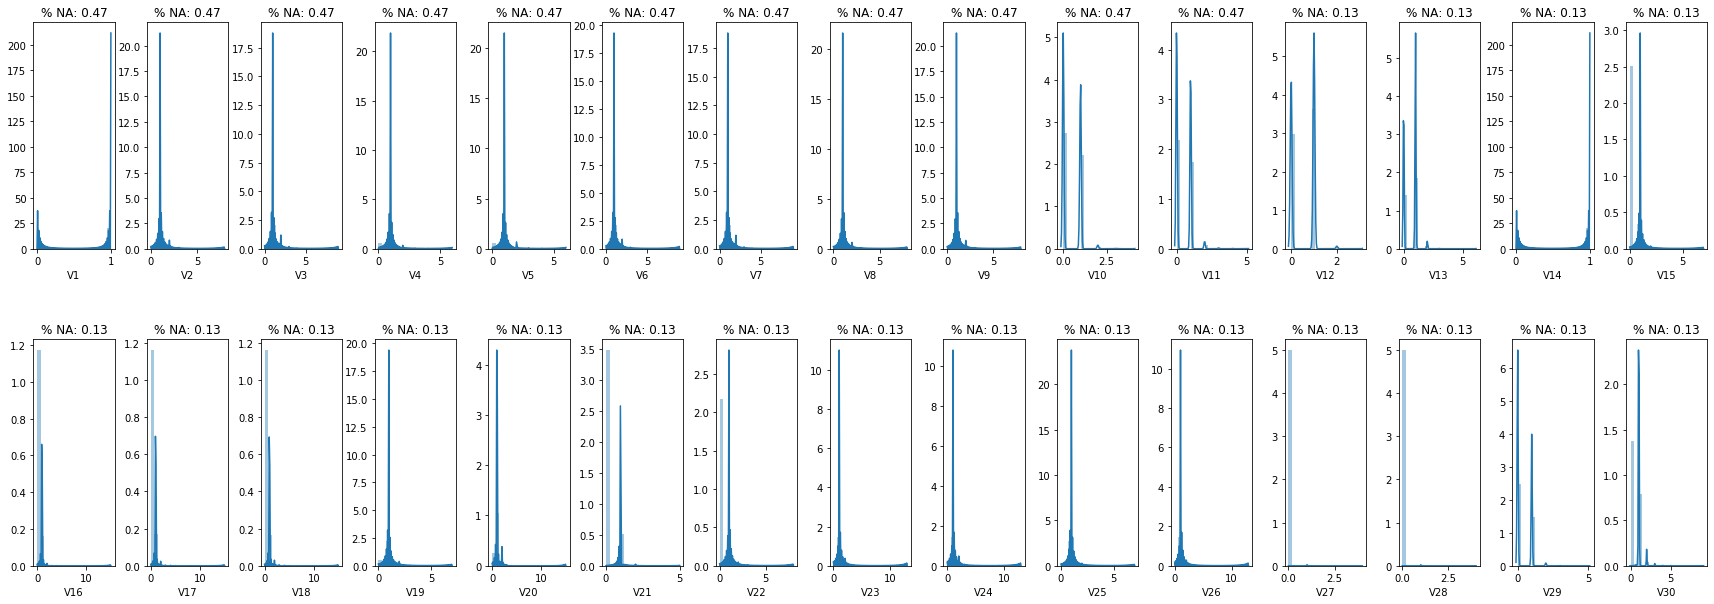

In [55]:
plot_VXXX(train)

# NA columns
Let's determine columns that have an NA/NULL count of > 98%

In [0]:
empty_cols = [col for col in train.columns if sum(train[col].isnull())/len(train) > 0.99]

In [57]:
# Ratio of fraudulent cases to non-fraudulent cases in these empty columns - Do they contribute significantly to the information we have on fraudulent cases?
statistics.mean([train[~train[col].isnull()]['isFraud'].sum()/(0.01*len(train)) for col in empty_cols])

0.07149764998513601

Dropping these columns that are mostly empty makes relative sense. On average, in the rows that are not null in these columns, the ratio of fraudulent cases to non-fraudulent is ~7% - roughly double the ratio in our main train dataframe, but still very low when not considered realtively.